# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [4]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4589.879645,1.0001,-131.886217,2404.94,2273.053783
OMUSDT,526.319895,2467.463902,0.5376,0.000000,1941.14,1941.140000
BTCUSDT,601.021649,906.458741,0.1975,3.537078,305.44,308.977078
JASMYUSDT,387.458505,415.129664,0.0904,0.000000,27.67,27.670000
SOLUSDT,281.200518,414.559195,0.0903,0.000000,133.36,133.360000
ETHUSDT,250.747339,228.848090,0.0499,0.000000,-21.90,-21.900000
TRXUSDT,76.868953,124.356495,0.0271,-10.723889,47.49,36.766111
BBUSDT,60.176053,31.908583,0.0070,-39.733101,-28.27,-68.003101
BNBUSDT,1.142121,1.154973,0.0003,-10.606040,0.01,-10.596040
PEPEUSDT,0.000004,0.000003,0.0000,-38.521986,-0.00,-38.521986


In [19]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [20]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [21]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [22]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [24]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [25]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [26]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [27]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
    
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [28]:
# pnl_history['Total']-pnl_history['Total'].shift(1)

In [29]:
# pnl_history['Total']


In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
#realized_pnl_time=realized_pnl_time.resample("D").last().dropna().sort_index()

#pd.DataFrame(realized_pnl_time)

In [33]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [34]:
pnl_history['Total']

2024-09-23    -374.733177
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-26    1935.665840
2025-01-27    1887.630388
2025-01-28    1745.622103
2025-01-29    1856.722021
2025-01-30    2444.042843
Name: Total, Length: 130, dtype: float64

In [35]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-26    242.122985
2025-01-27    -48.035452
2025-01-28   -142.008285
2025-01-29    111.099918
2025-01-30    587.320822
Name: Total, Length: 130, dtype: float64

In [36]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [37]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [38]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [39]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_101300\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [40]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [41]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [42]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

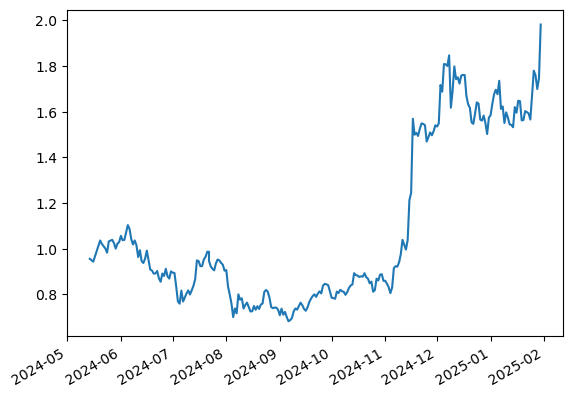

In [43]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [45]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [48]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [49]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [52]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4217
XRPUSDT,0.1882
BNBUSDT,0.1776
SUIUSDT,0.0644
PEPEUSDT,0.0525
RAYUSDT,0.0362
DEXEUSDT,0.0287
AAVEUSDT,0.0168
TRXUSDT,0.0140
BONKUSDT,0.0000


In [53]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.393082
BTCUSDT,0.300000
XRPUSDT,0.135125
BNBUSDT,0.049234
SUIUSDT,0.048236
DEXEUSDT,0.025410
RAYUSDT,0.023968
PEPEUSDT,0.017349
TRXUSDT,0.007595


### Current results

In [55]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [56]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.445930
BTCUSDT,0.415617
TRXUSDT,0.138453


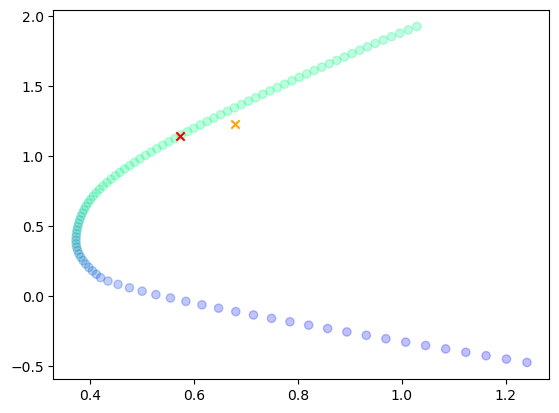

In [57]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [59]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2467.463902,0.537588,0.445930,0.091658
BTCUSDT,906.458741,0.197491,0.415617,-0.218126
JASMYUSDT,415.129664,0.090445,0.000000,0.000000
SOLUSDT,414.559195,0.090320,0.000000,0.000000
ETHUSDT,228.848090,0.049859,0.000000,0.000000
TRXUSDT,124.356495,0.027094,0.138453,-0.111359
BBUSDT,31.908583,0.006952,0.000000,0.000000
BNBUSDT,1.154973,0.000252,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [60]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2467.463902,0.537588,0.393082,0.144506
BTCUSDT,906.458741,0.197491,0.300000,-0.102509
JASMYUSDT,415.129664,0.090445,0.000000,0.000000
SOLUSDT,414.559195,0.090320,0.000000,0.000000
ETHUSDT,228.848090,0.049859,0.000000,0.000000
TRXUSDT,124.356495,0.027094,0.007595,0.019499
BBUSDT,31.908583,0.006952,0.000000,0.000000
BNBUSDT,1.154973,0.000252,0.049234,-0.048982
PEPEUSDT,0.000003,0.000000,0.017349,-0.017349
XRPUSDT,0.000000,0.000000,0.135125,0.000000


# Risk Reward Analysis

In [62]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [63]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

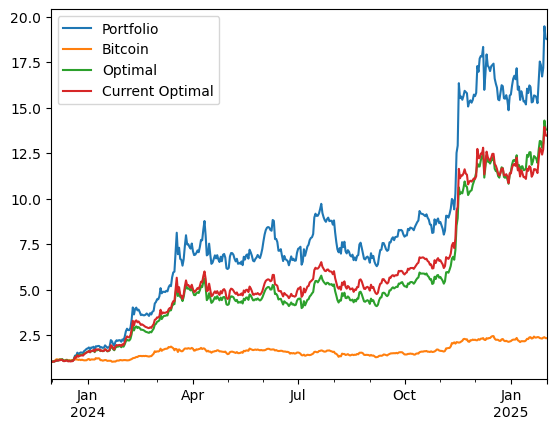

In [64]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [65]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

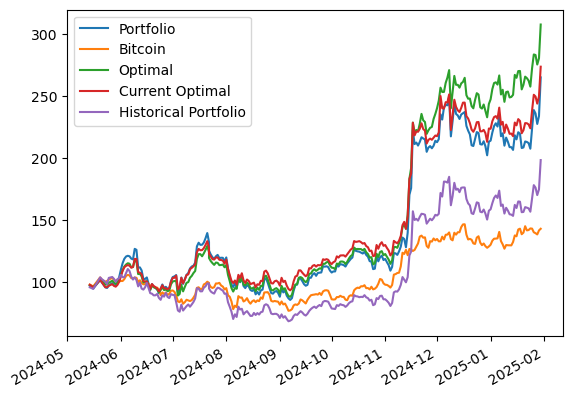

In [66]:
((1+current_perf).cumprod()*100).plot()

In [67]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-21,213.180875,144.886575,265.450097,228.007629,160.268527
2025-01-22,212.794613,141.521058,264.240745,227.882552,159.809659
2025-01-23,211.879837,141.798733,262.238514,226.931654,159.252001
2025-01-24,207.363764,143.102976,257.401827,223.787199,156.577799
2025-01-25,223.654982,142.934147,272.207144,238.081629,167.492235
2025-01-26,238.511451,140.002047,283.340167,250.839030,177.981837
2025-01-27,235.772092,139.267274,282.893870,249.418638,175.966487
2025-01-28,227.304997,138.244001,275.220411,243.701277,169.963707
2025-01-29,233.631369,141.476921,280.202528,249.516209,174.562610
2025-01-30,264.848599,142.820328,307.467602,273.472262,198.187203


## Volatilities

In [69]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.629412
 dtype: float64,
 0.6301250760540594)

In [70]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.679329
 dtype: float64,
 0.6793285183175595)

In [71]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.772487
Bitcoin            0.426459
Optimal            0.630125
Current Optimal    0.653071
dtype: float64

In [72]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.46373915619030526

In [73]:
days=120
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

3.1053752549693

In [74]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.8103752797113515

## Risk Contribution

In [76]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.072982,0.049234,0.004375,0.016425,0.001325,0.015100
BTCUSDT,0.397984,0.300000,0.024987,0.125414,0.041223,0.084190
DEXEUSDT,0.055027,0.025410,0.002880,0.014949,0.001378,0.013571
OMUSDT,25.795156,0.393082,0.937525,0.705940,0.595448,0.110492
PEPEUSDT,0.046662,0.017349,0.002292,0.014339,0.001170,0.013169
RAYUSDT,0.117758,0.023968,0.005074,0.022384,0.001946,0.020438
SUIUSDT,0.108691,0.048236,0.005618,0.029525,0.005251,0.024274
TRXUSDT,0.005966,0.007595,0.000485,0.002058,0.000066,0.001992
XRPUSDT,0.333150,0.135125,0.016764,0.068966,0.020644,0.048322


In [77]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.569187,0.445930,0.707901,0.749351,0.642071,0.107280
BTCUSDT,0.206320,0.415617,0.218483,0.168456,0.085207,0.083248
TRXUSDT,0.071102,0.138453,0.073616,0.082194,0.039822,0.042371


In [78]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.881397,0.534653,0.804101,0.764779,0.655803,0.108976
BTCUSDT,0.098301,0.198020,0.098620,0.066125,0.013743,0.052381
JASMYUSDT,-0.003754,0.089109,0.028407,0.077883,0.021030,0.056853
SOLUSDT,0.022467,0.089109,0.037134,0.052417,0.007523,0.044894
ETHUSDT,-0.001833,0.049505,0.015866,0.019538,0.001545,0.017993
TRXUSDT,0.015254,0.029703,0.014962,0.010752,0.001302,0.009450
BBUSDT,-0.007172,0.009901,0.000908,0.008505,0.000327,0.008178


# Value At Risk

## Historical

### Optimal Weights

In [82]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.052614035311833555, -0.07416699421569982)

### Current Weights

In [84]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04979677824486885, -0.07344892748523438)

In [85]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [86]:
var=historical_var.iloc[row]
var

OMUSDT      -0.023531
BTCUSDT     -0.008236
JASMYUSDT   -0.006891
SOLUSDT     -0.007407
ETHUSDT     -0.002243
TRXUSDT     -0.001225
BBUSDT      -0.000409
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049942
Name: 2024-07-07 00:00:00, dtype: float64

In [87]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.050316
BTCUSDT     -0.006229
JASMYUSDT   -0.007742
SOLUSDT     -0.005368
ETHUSDT     -0.002032
TRXUSDT     -0.000877
BBUSDT      -0.000885
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.073449
dtype: float64

## Parametric

### Optimal Weights

In [90]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06529106448554445, -0.08368509269091529)

### Current Weights

In [92]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.07038933028041554, -0.09021965984751557)

## Multivariate

### Optimal Weights

In [95]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05703961239283982, -0.07325381742153422)

### Current Weights

In [97]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06554639463542684, -0.08406058067085218)

In [98]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.049647
BTCUSDT     -0.004725
JASMYUSDT   -0.004723
SOLUSDT     -0.003227
ETHUSDT     -0.001514
TRXUSDT     -0.000846
BBUSDT      -0.000662
Portfolio   -0.065344
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [102]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05816425757290065, -0.07481548842250035)

### Current Weights

In [104]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06536940913231015, -0.0822003342623569)

In [105]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.049055
BTCUSDT     -0.004841
JASMYUSDT   -0.005490
SOLUSDT     -0.003334
ETHUSDT     -0.001557
TRXUSDT     -0.000657
BBUSDT      -0.000700
Portfolio   -0.065633
dtype: float64

## Student Copula

### Optimal Weights

In [108]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058228724497132046, -0.07588423149304188)

### Current Weights

In [110]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06519411553948795, -0.08394649566521542)

In [111]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.050417
BTCUSDT     -0.004103
JASMYUSDT   -0.005812
SOLUSDT     -0.003854
ETHUSDT     -0.001494
TRXUSDT     -0.000542
BBUSDT      -0.000693
Portfolio   -0.066916
dtype: float64

## Gumbel Copula

### Optimal Weights

In [114]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10699561131435333, -0.15871139943883794)

### Current Weights

In [116]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12718354003087406, -0.1783063736433141)

In [117]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.120080
BTCUSDT     -0.001318
JASMYUSDT   -0.001848
SOLUSDT     -0.001159
ETHUSDT      0.000191
TRXUSDT     -0.000046
BBUSDT      -0.000043
Portfolio   -0.124303
dtype: float64

## Monte Carlo

### Optimal

In [120]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [121]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06697433116652149, -0.0846439294046579)

### Current Weights

In [123]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0735667309373417, -0.09051415331917609)

In [124]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.054615
BTCUSDT     -0.004744
JASMYUSDT   -0.005914
SOLUSDT     -0.003819
ETHUSDT     -0.001520
TRXUSDT     -0.000801
BBUSDT      -0.000553
Portfolio   -0.071965
dtype: float64

## VaR Violation

In [126]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.055429,-0.098227,-0.086345,-0.019423
2024-01-15,-0.055429,-0.098232,-0.082812,0.016879
2024-01-16,-0.055429,-0.098007,-0.081594,0.044720
2024-01-17,-0.055429,-0.099671,-0.083086,-0.026554
2024-01-18,-0.055429,-0.102101,-0.088713,-0.037055
...,...,...,...,...
2025-01-28,-0.056851,-0.068828,-0.064208,-0.027125
2025-01-29,-0.056851,-0.067995,-0.061435,0.018102
2025-01-30,-0.056851,-0.076474,-0.068468,0.097305
2025-01-31,-0.056851,-0.078353,-0.070393,-0.032709


In [127]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.038388,-0.084413,-0.081091,-0.016247
2024-05-29,-0.038388,-0.081894,-0.074643,-0.008392
2024-05-30,-0.038388,-0.071653,-0.068193,0.031892
2024-05-31,-0.038388,-0.073483,-0.066102,0.041696
2024-06-01,-0.038388,-0.078092,-0.071968,0.057958
...,...,...,...,...
2025-01-28,-0.050180,-0.086858,-0.078937,-0.035912
2025-01-29,-0.050180,-0.087023,-0.076669,0.027832
2025-01-30,-0.050180,-0.111948,-0.099148,0.133617
2025-01-31,-0.050180,-0.114447,-0.100249,-0.034281


<Axes: >

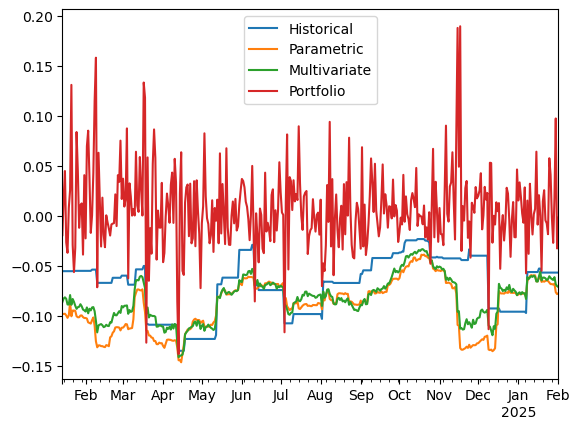

In [128]:
var_data.plot()

<Axes: >

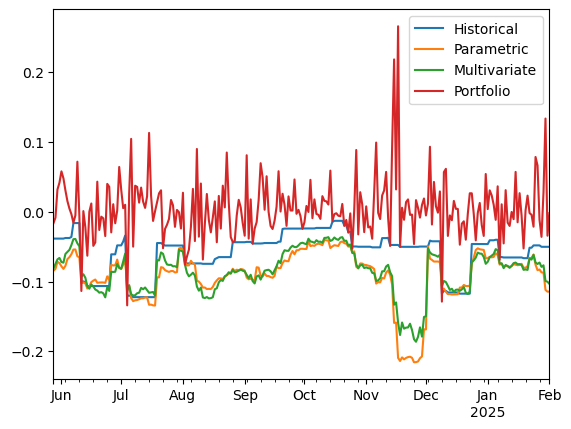

In [129]:
current_var_data.plot()

In [130]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.023377,0.01039,0.012987
Kupiec Stat,7.099449,18.55746,15.56739
P-value,0.007711,0.000016,0.00008


In [131]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.052,0.016,0.012
Kupiec Stat,0.020792,8.185171,10.812334
P-value,0.885347,0.004223,0.001008


# Principal Component Analysis

## Historical PCA

In [134]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77778761, 0.07044649, 0.05705994, 0.05198587, 0.0427201 ])

In [135]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.016147
ADAUSDT      0.016314
ALGOUSDT     0.018623
APTUSDT      0.016931
ARBUSDT      0.017979
ARUSDT       0.021408
ATOMUSDT     0.016425
AVAXUSDT     0.018191
BCHUSDT      0.015223
BNBUSDT      0.008501
BONKUSDT     0.023123
BTCUSDT      0.009498
DEXEUSDT     0.014447
DOGEUSDT     0.017519
DOTUSDT      0.017325
ENSUSDT      0.020194
EOSUSDT      0.017306
ETCUSDT      0.015788
ETHUSDT      0.012490
FDUSDUSDT    0.000042
FETUSDT      0.022088
FILUSDT      0.018960
FLOKIUSDT    0.023121
GALAUSDT     0.022352
GRTUSDT      0.020921
HBARUSDT     0.018152
ICPUSDT      0.016974
IMXUSDT      0.019046
INJUSDT      0.019502
IOTAUSDT     0.019585
JASMYUSDT    0.020027
LDOUSDT      0.019550
LINKUSDT     0.016272
LTCUSDT      0.012677
MKRUSDT      0.012966
NEARUSDT     0.020745
NEOUSDT      0.018489
OMUSDT       0.010906
OPUSDT       0.018620
PEPEUSDT     0.023803
QNTUSDT      0.014506
RAYUSDT      0.018637
SANDUSDT     0.020227
SEIUSDT      0.020529
SHIBUSDT     0.017821
SOLUSDT   

<Axes: >

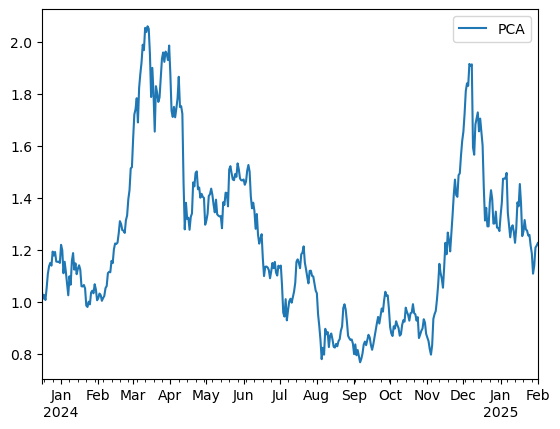

In [136]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

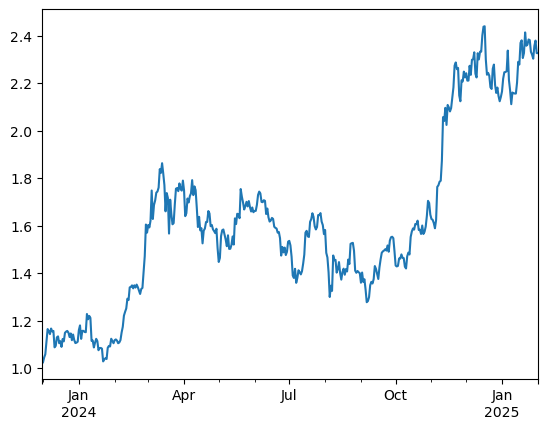

In [137]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [138]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.441097
ETHUSDT      0.441502
ATOMUSDT     0.461713
DOTUSDT      0.463794
ETCUSDT      0.468351
ADAUSDT      0.508226
WBTCUSDT     0.516668
BTCUSDT      0.517141
EOSUSDT      0.530571
AVAXUSDT     0.533859
FILUSDT      0.551767
IOTAUSDT     0.553664
ARBUSDT      0.570751
GRTUSDT      0.577545
XTZUSDT      0.586046
LINKUSDT     0.598710
SOLUSDT      0.606140
IMXUSDT      0.606889
VETUSDT      0.615416
dtype: float64

<Axes: >

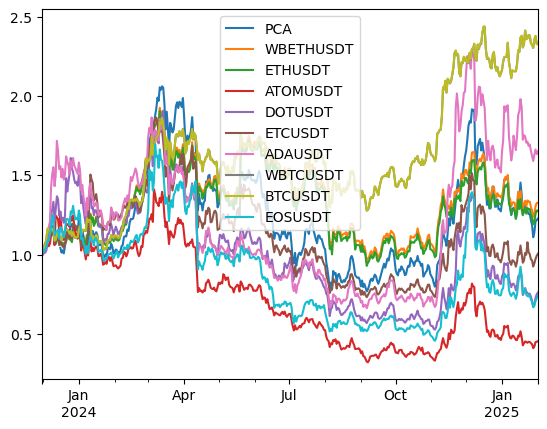

In [139]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

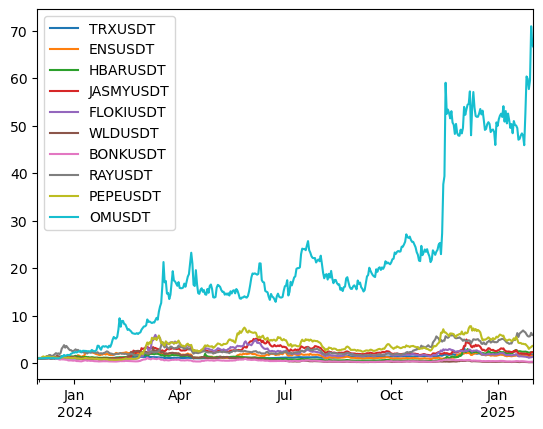

In [140]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [142]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.55909338, 0.14821269, 0.12198202, 0.0981405 , 0.07257141])

In [143]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095234
BTCUSDT      0.059994
JASMYUSDT    0.176665
SOLUSDT      0.097895
ETHUSDT      0.084158
TRXUSDT      0.054879
BBUSDT       0.206585
BNBUSDT      0.065065
PEPEUSDT     0.159524
Name: PC1, dtype: float64

<Axes: >

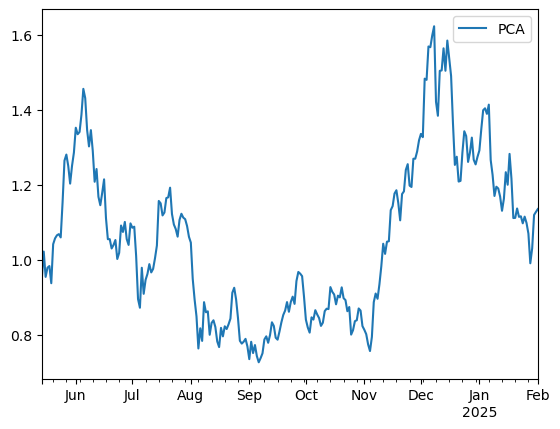

In [144]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

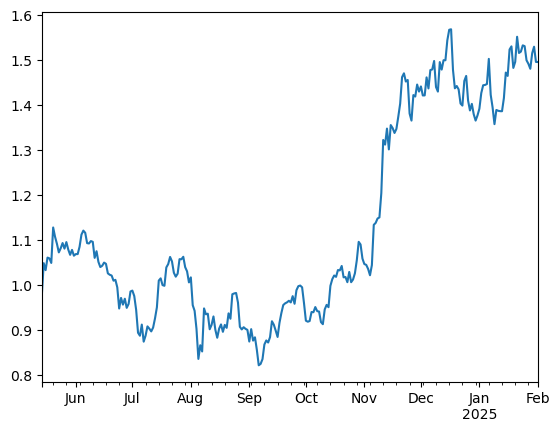

In [145]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [146]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.429731
BNBUSDT      0.459140
BTCUSDT      0.476960
SOLUSDT      0.485719
JASMYUSDT    0.689410
PEPEUSDT     0.741667
BBUSDT       0.767336
TRXUSDT      0.898691
OMUSDT       0.956196
dtype: float64

<Axes: >

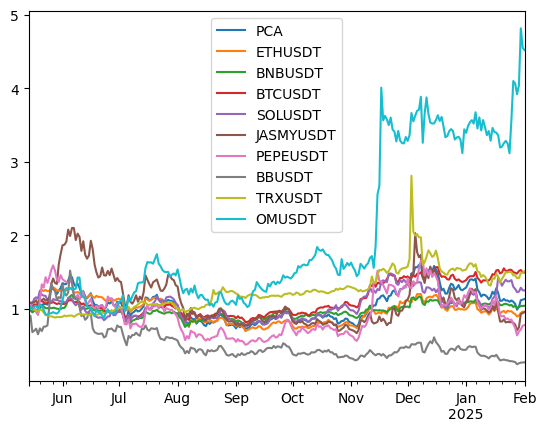

In [147]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [149]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.898470
BBUSDT       1.546396
JASMYUSDT    1.320494
SOLUSDT      1.156686
BTCUSDT      1.000000
ETHUSDT      0.966421
OMUSDT       0.868944
BNBUSDT      0.658757
TRXUSDT      0.317313
Name: BTCUSDT, dtype: float64

In [150]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.178156
PEPEUSDT     1.925181
BBUSDT       1.723706
SOLUSDT      1.281242
ETHUSDT      1.100440
BTCUSDT      1.000000
TRXUSDT      0.985427
OMUSDT       0.663523
BNBUSDT      0.608922
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [152]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [153]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.234936
ETHUSDT,0.221840
BBUSDT,0.189833
PEPEUSDT,0.137925
JASMYUSDT,0.111962
TRXUSDT,0.104442
BNBUSDT,0.099426
SOLUSDT,0.089674
OMUSDT,0.003553


### Regression to PCA

In [155]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.6342984110805661

In [156]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.283258
BNBUSDT      1.176365
ETHUSDT      1.016409
PCA          1.000000
SOLUSDT      0.743610
JASMYUSDT    0.432828
PEPEUSDT     0.405535
BBUSDT       0.376736
TRXUSDT      0.250458
OMUSDT       0.237582
dtype: float64

In [157]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.828366
BTCUSDT      1.426133
ETHUSDT      1.321491
TRXUSDT      1.125489
PCA          1.000000
BBUSDT       0.724787
PEPEUSDT     0.527112
JASMYUSDT    0.397860
OMUSDT       0.236969
SOLUSDT      0.049006
dtype: float64

### Correlation Matrix

<Axes: >

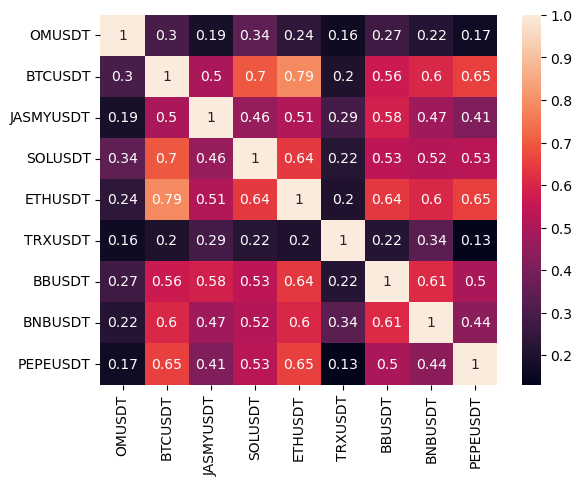

In [159]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

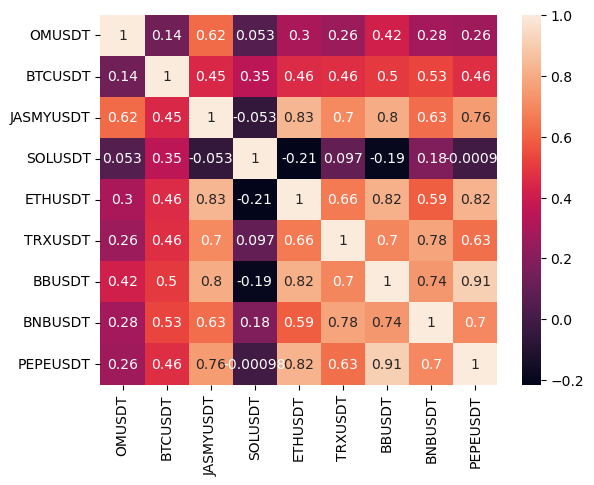

In [160]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [162]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [163]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-06-26,0.003753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.985235,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-07-26,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645240,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.103157,0.0
2024-08-25,0.885491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114509,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-09-24,0.157776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-24,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.515250,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-23,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.202212,0.188793,0.0
2024-12-23,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-01-22,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.432831,0.0
2025-02-01,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [164]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

OMUSDT      0.509324
LDOUSDT     0.469387
ETCUSDT     0.017523
AAVEUSDT    0.003767
LTCUSDT     0.000000
MKRUSDT     0.000000
Name: 2025-02-01 00:00:00, dtype: float64